In [3]:
from sdm.utils import set_project_wd
set_project_wd()
import nest_asyncio
nest_asyncio.apply()

Current Working Directory: /Users/matthewwhittle/Data Science/shefflied-bats


# About
This notebookmgets lidar data which will be used for two purposes:
 - to generate the elevation data
 - to fill gaps in the woody vegetation data

In [4]:
urls = {
    "DTM_2m":"https://environment.data.gov.uk/image/rest/services/SURVEY/LIDAR_Composite_2m_DTM_2022_Elevation/ImageServer",
    "DSM_2m":"https://environment.data.gov.uk/image/rest/services/SURVEY/LIDAR_Composite_2m_First_Return_DSM_2022_Elevation/ImageServer",
}
dl_resolution = 2 # resolution of the downloaded data in meters

In [5]:
import rioxarray as rxr
import xarray as xr
from shapely.geometry import box
import geopandas as gpd


s2_image = xr.open_mfdataset("data/raw/big-files/sentinel-2/*.tif", engine="rasterio", chunks = "auto")
bbox = s2_image.rio.bounds()

boundary = gpd.GeoDataFrame({"geometry": [box(*bbox)]}, crs=s2_image.rio.crs)
boundary = boundary.to_crs("EPSG:27700")
boundary




,geometry
0,"POLYGON ((497270.000 357330.000, 497270.000 44..."


# DTM Data

In [6]:
from functools import cache
from sdm.extract import ImageTileDownloader
dtm_downloader = ImageTileDownloader(
    base_url=urls["DTM_2m"],
    cache_folder = "data/raw/big-files/dtm-2m-cache",
)

In [10]:
dtm_image = dtm_downloader.download_image(
    boundary.geometry[0], target_resolution=dl_resolution
)

## DSM Data

In [8]:
dsm_downloader = ImageTileDownloader(
    base_url=urls["DSM_2m"],
    cache_folder="data/raw/big-files/dsm-2m-cache",
)

dsm_image = dsm_downloader.download_image(
    boundary.geometry[0], target_resolution=dl_resolution
)

## Calculate Terrain Statistics

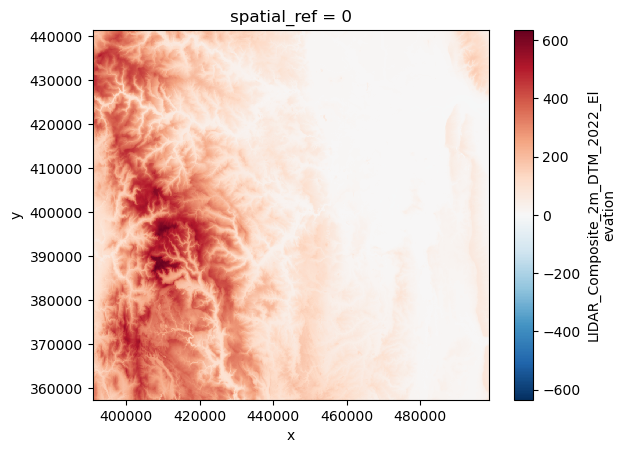

In [11]:
dtm_image.coarsen(x=50,y=50).mean().plot()

In [12]:
# Write some data for modelling
dtm_image_10m = dtm_image.coarsen(x=5,y=5).mean()
dsm_image_10m = dsm_image.coarsen(x=5,y=5).mean()

dtm_image.rio.to_raster("data/processed/dtm-10m.tif")
dsm_image.rio.to_raster("data/processed/dsm-10m.tif")

In [13]:
dtm_image

<xarray.DataArray 'LIDAR_Composite_2m_DTM_2022_Elevation' (y: 42000, x: 54000)>
dask.array<getitem, shape=(42000, 54000), dtype=float32, chunksize=(2000, 2000), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 3.908e+05 3.908e+05 ... 4.988e+05 4.988e+05
  * y            (y) float64 4.413e+05 4.413e+05 ... 3.573e+05 3.573e+05
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:    Area
    DataType:         Generic
    SourceBandIndex:  0

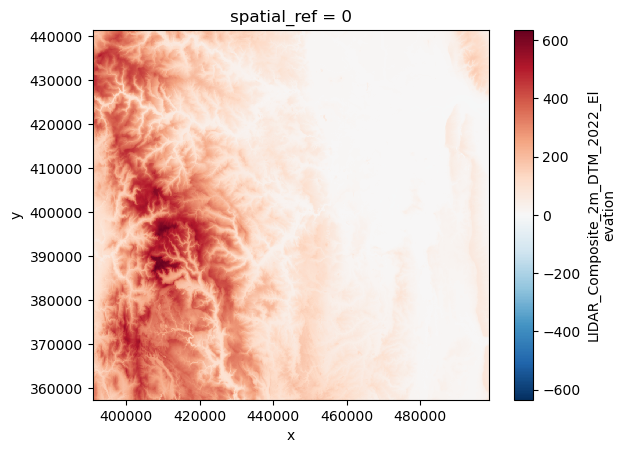

In [14]:
target_resolution = 100
scale_factor = round(target_resolution / dl_resolution)

dtm_100m = dtm_image.coarsen(x=scale_factor,y=scale_factor).mean().compute()
dtm_100m.plot()

## Vegetation Height Model


In [15]:
buildings = rxr.open_rasterio("data/processed/buildings-01.tif")
buildings = buildings.rio.reproject_match(dtm_image)

In [16]:
chm = dsm_image - dtm_image
vhm = chm.where(buildings == 0, 0)

In [31]:
vhm = vhm.squeeze()
vhm_100m = vhm.coarsen(x=scale_factor, y=scale_factor)
vhm_100m_stats = vhm_100m.mean().to_dataset(name="veg_height_mean")
vhm_100m_stats["veg_height_std"] = vhm_100m.std()
vhm_100m_stats["veg_height_max"] = vhm_100m.max()

vhm_100m_stats

<xarray.Dataset>
Dimensions:          (x: 1080, y: 840)
Coordinates:
  * x                (x) float64 3.908e+05 3.91e+05 ... 4.986e+05 4.988e+05
  * y                (y) float64 4.413e+05 4.412e+05 ... 3.575e+05 3.574e+05
    spatial_ref      int64 0
    band             int64 1
Data variables:
    veg_height_mean  (y, x) float32 dask.array<chunksize=(40, 40), meta=np.ndarray>
    veg_height_std   (y, x) float32 dask.array<chunksize=(40, 40), meta=np.ndarray>
    veg_height_max   (y, x) float32 dask.array<chunksize=(40, 40), meta=np.ndarray>

In [32]:
from sdm.geo import reproject_to_model_raster
vhm_100m_stats = reproject_to_model_raster(vhm_100m_stats)
vhm_100m_stats.rio.to_raster("data/evs/veg-height-100m.tif")

/Users/matthewwhittle/opt/miniconda3/envs/bats/lib/python3.11/site-packages/pygeos/constructive.py:175: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/matthewwhittle/opt/miniconda3/envs/bats/lib/python3.11/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
/Users/matthewwhittle/opt/miniconda3/envs/bats/lib/python3.11/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
/Users/matthewwhittle/opt/miniconda3/envs/bats/lib/python3.11/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


# Write the DTM

In [33]:


dtm_100m = reproject_to_model_raster(dtm_100m)

dtm_100m.rio.to_raster("data/evs/dtm-100m.tif")

/Users/matthewwhittle/opt/miniconda3/envs/bats/lib/python3.11/site-packages/pygeos/constructive.py:175: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
